# BOOTSTRAP КАК МЕТОД ПРОВЕРКИ СТАТИСТИЧЕСКИХ ГИПОТЕЗ

## > Описание эксперимента

Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

## Описание колонок

- value – значения метрики  
- experimentVariant – Вариант теста (Control – контроль, Treatment – тест)  

## Задача

Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

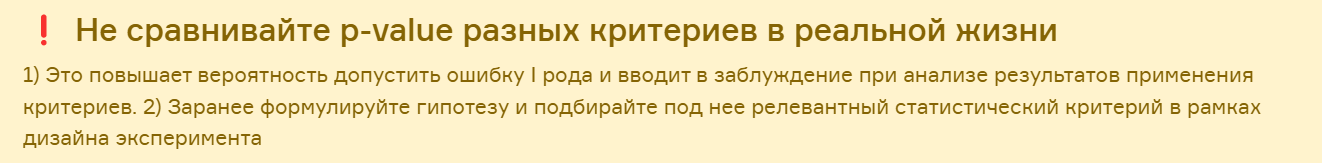

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy import stats 
from tqdm.auto import tqdm
from scipy.stats import norm

sns.set(rc={'figure.figsize':(6,4)}, style='whitegrid')

In [3]:
AB_df = pd.read_csv("hw_bootstrap8.csv", sep=";", decimal=",")

In [4]:
AB_df

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [5]:
AB_df.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

Посмотрим на размеры групп:

In [6]:
AB_df.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,500


Посмотрим на медиану и средние наших групп:

In [7]:
AB_df.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.025847


In [8]:
AB_df.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,27.321499


Построим боксплоты для наших групп:

<Axes: xlabel='experimentVariant', ylabel='value'>

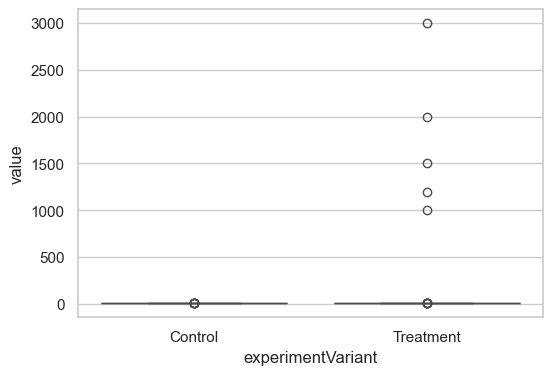

In [9]:
sns.boxplot(x="experimentVariant", y="value", data=AB_df)

Данный боксплот показывает наличие выбросов в *тестовой* группе.

Посмотрим на распределение наших групп:

•*Распределение в контрольной группе*:

C:\Users\konst\AppData\Local\Temp\ipykernel_5356\972188102.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(AB_df[AB_df['experimentVariant'] == 'Control']['value'], kde=False)


<Axes: xlabel='value'>

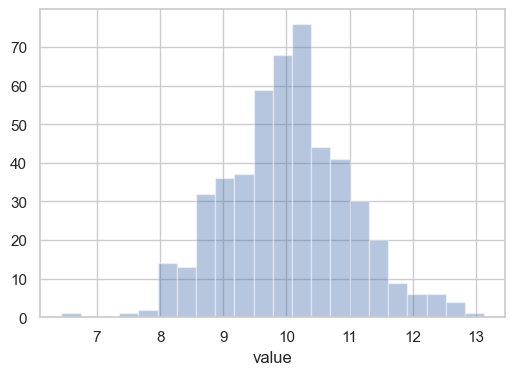

In [10]:
sns.distplot(AB_df[AB_df['experimentVariant'] == 'Control']['value'], kde=False)

•*Распределение в тестовой группе:*

<Axes: xlabel='value', ylabel='Count'>

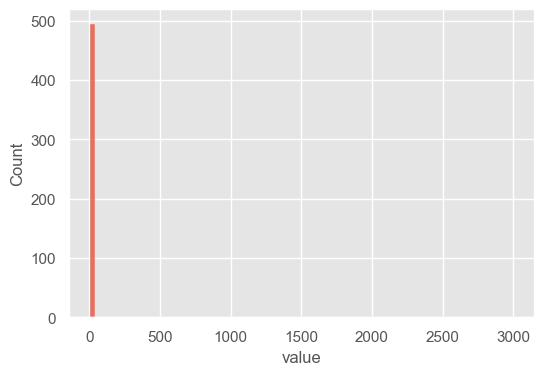

In [28]:
sns.histplot(data=AB_df[AB_df.experimentVariant == 'Treatment'],x='value',bins=100)

In [30]:
AB_df[AB_df.experimentVariant == 'Treatment']['value'].round(0).value_counts()

value
10.0      213
9.0       113
11.0      109
12.0       28
8.0        25
13.0        6
6.0         1
1000.0      1
1200.0      1
1500.0      1
2000.0      1
3000.0      1
Name: count, dtype: int64

•*Та же проверка без выбросов:*

Отсечем выбросы на уровне value<50:

C:\Users\konst\AppData\Local\Temp\ipykernel_5356\4233559182.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(AB_df[AB_df.experimentVariant == 'Treatment'].query("value < 50").value, kde=False)


<Axes: xlabel='value'>

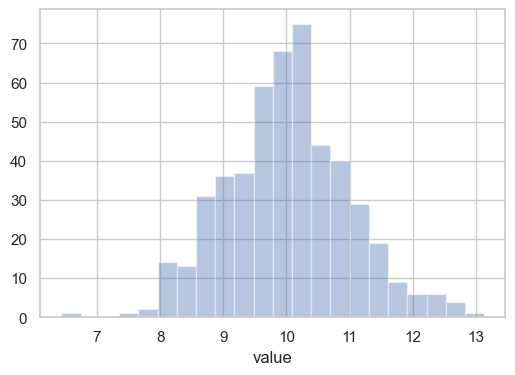

In [12]:
sns.distplot(AB_df[AB_df.experimentVariant == 'Treatment'].query("value < 50")['value'], kde=False)

Контрольная группа довольно схожа с нормальным распределением, тестовая же, как и ожидалось из боксплота, имеет вот такой вид, где много небольших и схожих по значению наблюдений и какое-то количество выбросов.
Тестовая без выбросов имеет схожее с нормальным распределение.

__Проведем t-тест:__

Требованием для проверки теста является соблюдение гомогенности дисперсий и нормальность данных обеих групп. На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов.

Выполним проверки на эти требования:

In [13]:
pv_cont = stats.shapiro(AB_df[AB_df['experimentVariant'] == 'Control'].value)
print(f'Уровень значимости p-value = {round(pv_cont[1],3)}')

Уровень значимости p-value = 0.224


In [14]:
pv_test = stats.shapiro(AB_df[AB_df['experimentVariant'] == 'Treatment'].value)
print(f'Уровень значимости p-value = {pv_test[1]}')

Уровень значимости p-value = 1.0974195363312355e-43


In [15]:
pv_test_filtered = stats.shapiro(AB_df[AB_df['experimentVariant'] == 'Treatment'].query("value < 50").value)
print(f'Уровень значимости p-value = {round(pv_test_filtered[1],3)}')

Уровень значимости p-value = 0.172


__Тезисно:__

• Данные результаты говорят следующее:  
    - контрольная группа имеет нормальное распределение p-value>0,05;  
    - тестовая группа имеет ненормальное распределение p-value<0,05;  
    - тестовая группа без выбросов имеет нормальное распределение p-value>0,05;  
*Всё выше справедливо, если принимаем за критический уровень α=0.05.



In [16]:
f_test = stats.f_oneway(AB_df[AB_df['experimentVariant']  == 'Treatment'].value, AB_df[AB_df.experimentVariant == 'Control'].value)
print(f'Уровень значимости p-value = {round(f_test[1],3)}')

Уровень значимости p-value = 0.038


In [17]:
f_test_filtered = stats.f_oneway(AB_df[AB_df['experimentVariant']  == 'Treatment'].query("value < 50").value, AB_df[AB_df.experimentVariant == 'Control'].value)
print(f'Уровень значимости p-value = {round(f_test_filtered[1],3)}')

Уровень значимости p-value = 0.934


__Тезисно:__

• Данные результаты говорят следующее:  
    - дисперсии контрольной и тестовой групп статистически различаются p-value<0,05;  
    **- дисперсии контрольной и тестовой групп без выбросов статистически не различаются p-value>0,05**
    
*Всё выше справедливо, если принимаем за критический уровень α=0.05.

In [18]:
t_test = ttest_ind(AB_df[AB_df['experimentVariant']  == 'Treatment'].value, 
             AB_df[AB_df['experimentVariant']  == 'Control'].value)
print(f'P-value = {round(t_test[1],3)}.')

P-value = 0.038.


Без выбросов:

In [19]:
t_test_filtered = ttest_ind(AB_df[AB_df['experimentVariant']  == 'Treatment'].query("value < 50").value, 
             AB_df[AB_df['experimentVariant']  == 'Control'].value)
print(f'P-value = {round(t_test_filtered[1],3)}.')

P-value = 0.934.


__Результаты:__  
• полученные результаты подтверждают тот факт, что t-тест чувствителен к заметным выбросам - наличие выбросов в тестовой группе показало статистически значимые различия меж группами при критическом уровне α=0.05. Стоило убрать выбросы и мы получаем обратную картину;  
• решением убрать для t-теста группы treatment значения value меньше 50 послужило то, что большая доля наших наблюдений были сосредоточены ближе к значению равному 10, а наблюдений сильно превышающих было незначительно;  
• сделаем предположение о том, что статзначимых различий меж группами нет.

__Проведем U-тест Mann-Whitney:__

In [20]:
mw_test = mannwhitneyu(AB_df[AB_df['experimentVariant']  == 'Treatment'].value, 
             AB_df[AB_df['experimentVariant']  == 'Control'].value)
print(f'P-value = {round(mw_test[1],3)}.')

P-value = 0.859.


__Результаты:__  
• данный тест менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов, как итог - различий нету.

__Проведем бутстрап:__

In [21]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Проведем сравнение двух групп:

  0%|          | 0/1000 [00:00<?, ?it/s]

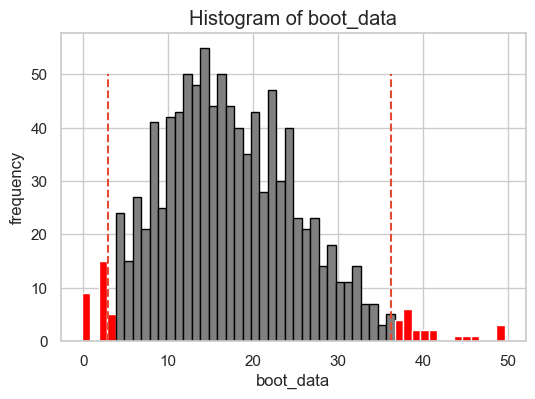

{'boot_data': [13.255951420459915,
  12.636605078599578,
  18.625929573403514,
  21.934386719511792,
  23.730814501942735,
  15.80415101424632,
  31.95885709184647,
  12.090036314785175,
  17.197880471116562,
  16.240233942939206,
  7.937381687460265,
  18.595565881355476,
  14.316605716250777,
  21.859260030520133,
  17.749321505124513,
  9.370759064916953,
  26.514952057546335,
  12.941254659020919,
  19.535425844181802,
  11.917989377009004,
  12.367242257787606,
  14.234280342980819,
  16.297087811134944,
  36.935528213642705,
  12.986276016908258,
  21.94482019103364,
  23.362844616594707,
  13.972269828625171,
  19.930317503232956,
  14.969619010558166,
  35.216153883104184,
  2.374231042774962,
  25.720426557872944,
  10.030420296955452,
  18.97844454556663,
  6.3975602511156495,
  24.372054895429716,
  2.0611066516570915,
  17.43313898509446,
  8.505781452045968,
  22.680170319284827,
  10.361547100077383,
  17.85696199787654,
  20.349601369041924,
  21.89593759482989,
  45.020

In [22]:
get_bootstrap(
    AB_df[AB_df.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    AB_df[AB_df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
             )

Та же проверка без выбросов в тестовой группе:

  0%|          | 0/1000 [00:00<?, ?it/s]

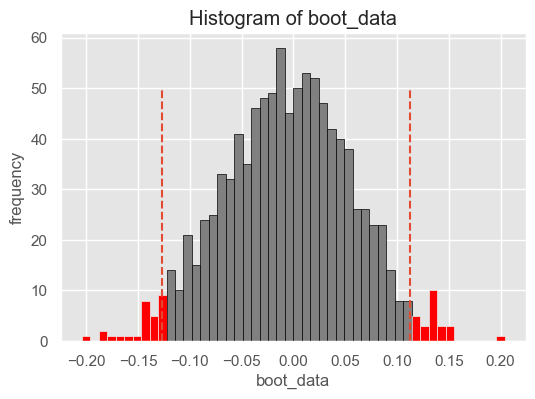

{'boot_data': [0.04444522976453058,
  0.03811335395096371,
  0.02213296873239301,
  -0.030443342196790013,
  -0.035195254168607804,
  0.04030906406464929,
  0.03330711174725742,
  0.03342465182711507,
  -0.054861795739807206,
  0.0586206443931232,
  0.08703303469454227,
  0.11258537071460673,
  -0.06447776676546546,
  -0.061780530871741846,
  0.016464330965421325,
  -0.14179246970607728,
  0.006214328499318356,
  0.0256427932161305,
  0.05179087256428794,
  -0.015790636203286468,
  -0.008975626722529384,
  0.012898292309314385,
  -0.008575852216543112,
  -0.0002297855123085668,
  -0.01576703598830953,
  0.02057955652579757,
  0.05603452761669736,
  0.01828832859630225,
  0.003814678963070861,
  -0.0348504902576785,
  0.03337069656581981,
  -0.07587554850949019,
  0.009919812827821062,
  0.14414388784576992,
  0.051103366317786225,
  0.1255953156448939,
  -0.018713709450631555,
  -0.0834531907890863,
  0.050187677781206474,
  -0.013857872435993457,
  0.07513322073242534,
  -0.0441735244

In [23]:
get_bootstrap(
    AB_df[AB_df.experimentVariant == 'Treatment'].query("value < 50").value, # числовые значения первой выборки
    AB_df[AB_df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
             )

• усредненная разность между средними в контрольной и тестовой группах равняется 20;  
• усредненная разность между средними в контрольной и тестовой без выбросов группах равняется 0.

Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки.

Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект).

## Итого
Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение. Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
Однако, убрав выбросы, мы уже не можем отклонить нулевую гипотезу, так как p-value сильно больше 0.05. U-критерий Манна-Уитни так же не дал отклонить нулевую гипотезу.